In [4]:
import pandas as pd

In [10]:
import matplotlib.pyplot as plt

In [19]:
import dhlab.graph_networkx_louvain as gnl

In [ ]:
import networkx as nx
from itertools import combinations

In [ ]:
def find_faces(G):
    # This is a naive way to find faces; there are more efficient algorithms
    cycle_generator = nx.cycle_basis(G)
    return [tuple(sorted(cycle)) for cycle in cycle_generator]

def dual_graph(G):
    faces = find_faces(G)
    G_dual = nx.Graph()
    
    for i, face1 in enumerate(faces):
        for j, face2 in enumerate(faces[i+1:], start=i+1):
            # Two faces are adjacent if they share more than one vertex
            if len(set(face1).intersection(set(face2))) > 1:
                G_dual.add_edge(i, j)
                
    return G_dual

# Create a simple square graph
G = nx.Graph([(1, 2), (2, 3), (3, 4), (4, 1), (1, 3), (2, 4)])

# Compute its dual
G_dual = dual_graph(G)

# Print the edges of the dual graph
print("Edges of the dual graph:", G_dual.edges())

In [12]:
def get_ndt():
    df = pd.read_csv('NDT/ndt_all_reduce.csv', index_col = 0)
    sent = pd.read_csv('NDT/setninger.csv', index_col = 0)
    return df, sent




def make_sentence_graph(indx):
    edges = ndt[ndt.sent_id == indx]["token_order head deprel".split()]
    nodes = ndt[ndt.sent_id == indx]["token_order form".split()]

    #edgelist = [(int(e[1].token_order), int(e[1]['head']), {'name':e[1].deprel}) for e in edges.iterrows()]
    edgelist = [(int(e[1]['head']), int(e[1].token_order), {'name':e[1].deprel}) for e in edges.iterrows()]
    nodelist = [(int(e[1].token_order), {'name':e[1]['form']}) for e in nodes.iterrows()] 

    G = nx.DiGraph()
    
    G.add_edges_from(edgelist)
    G.add_nodes_from(nodelist)
    
    # add name for root element
    G.nodes[0]['name'] = 'root'
   
    return G


def draw_graph(G, rank="BT"):
    edgelabels = {(x[0], x[1]):x[2]['name'] for x in G.edges(data=True)}
    nodelabels = {x[0]:x[1]['name'] for x in G.nodes(data=True)}
    pos =  nx.nx_agraph.graphviz_layout(G, prog="dot")
    G.graph.setdefault('graph', {})['rankdir'] = rank
    n = nx.dag_longest_path(G)
    fig = plt.figure(figsize=(16,1.4*len(n)))
    # nodes
    options = {"edgecolors": "tab:gray", "node_size": 0, "alpha": 0.9}
    nx.draw_networkx_edges(G, pos, width=1.2, alpha=0.3, arrows=True, edge_color='gray') #, connectionstyle="arc3,rad=0.3");
    nx.draw_networkx_edge_labels(G, pos, edge_labels = edgelabels, font_size=8,font_color='orange');
    nx.draw_networkx_labels(G, pos, labels = nodelabels, font_color='darkblue', font_size=12);


In [7]:
ndt, sent = get_ndt()

In [56]:
Gs = [make_sentence_graph(ix+1) for ix in range(1000)]

In [57]:
Gs[0]

In [193]:
def dual_dh_style(G):
    Gd = nx.Graph()
    edges = []
    # each edge is a node
    for node, x in enumerate(G.edges(data=True)):
        Gd.add_node(node, name=x[2]['name'], vs = (x[0],x[1]))
    for x in Gd.nodes(data = True):
        for y in Gd.nodes(data=True):
            if y != x:
                if set(x[1]['vs']) & set(y[1]['vs']) != set():
                    #print( set(x[1]['vs']) & set(y[1]['vs']))
                    Gd.add_edge(x[0], y[0])
    Gd.remove_edges_from(nx.selfloop_edges(Gd))
    return Gd

In [194]:
Gds = [dual_dh_style(G) for G in Gs]

In [195]:
Gds[0].edges(data=True)

EdgeDataView([(0, 1, {}), (0, 2, {}), (0, 3, {}), (1, 2, {}), (1, 3, {}), (1, 4, {}), (2, 3, {}), (2, 5, {})])

In [216]:
def draw_graph(G):
    pos = nx.spring_layout(G)
    #print(pos)
    nx.draw_networkx_nodes(G, pos)
    nx.draw_networkx_edges(G, pos)
    nx.draw_networkx_labels(G, pos, labels = {n[0]:n[1]['name'] for n in G.nodes(data=True)})

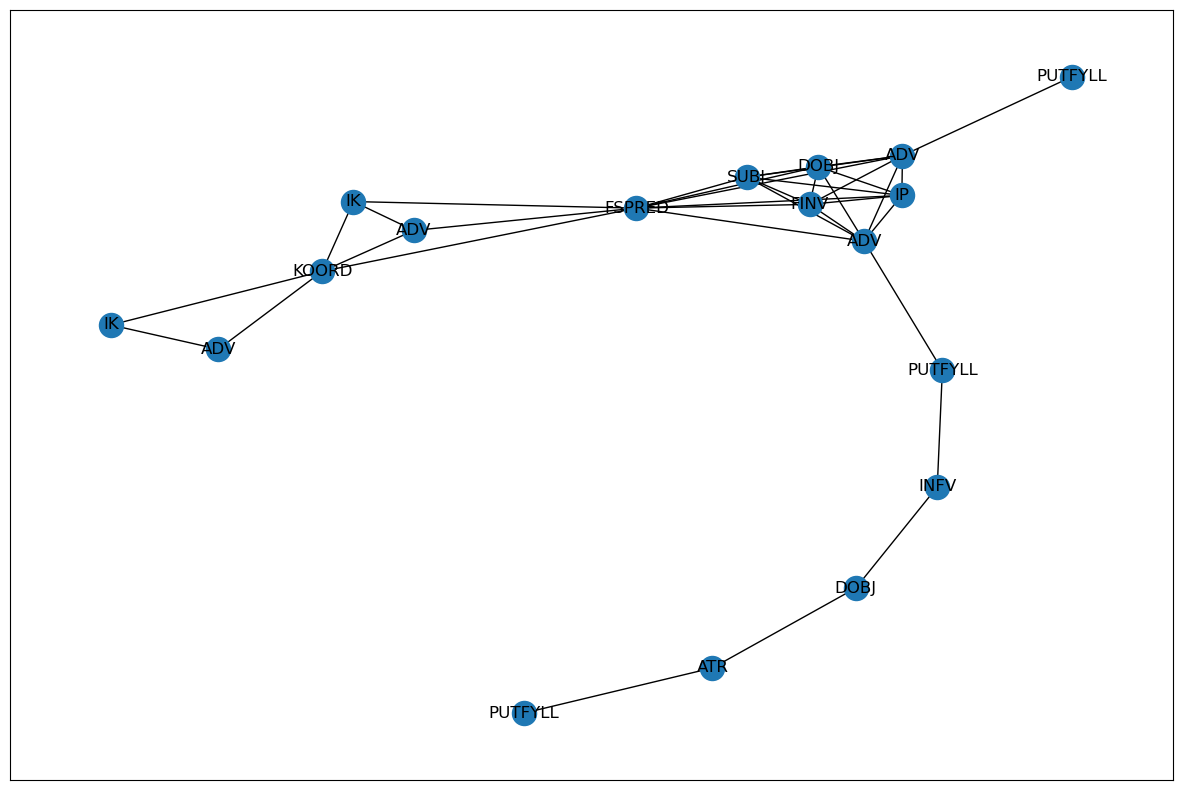

In [217]:
draw_graph(Gds[10])

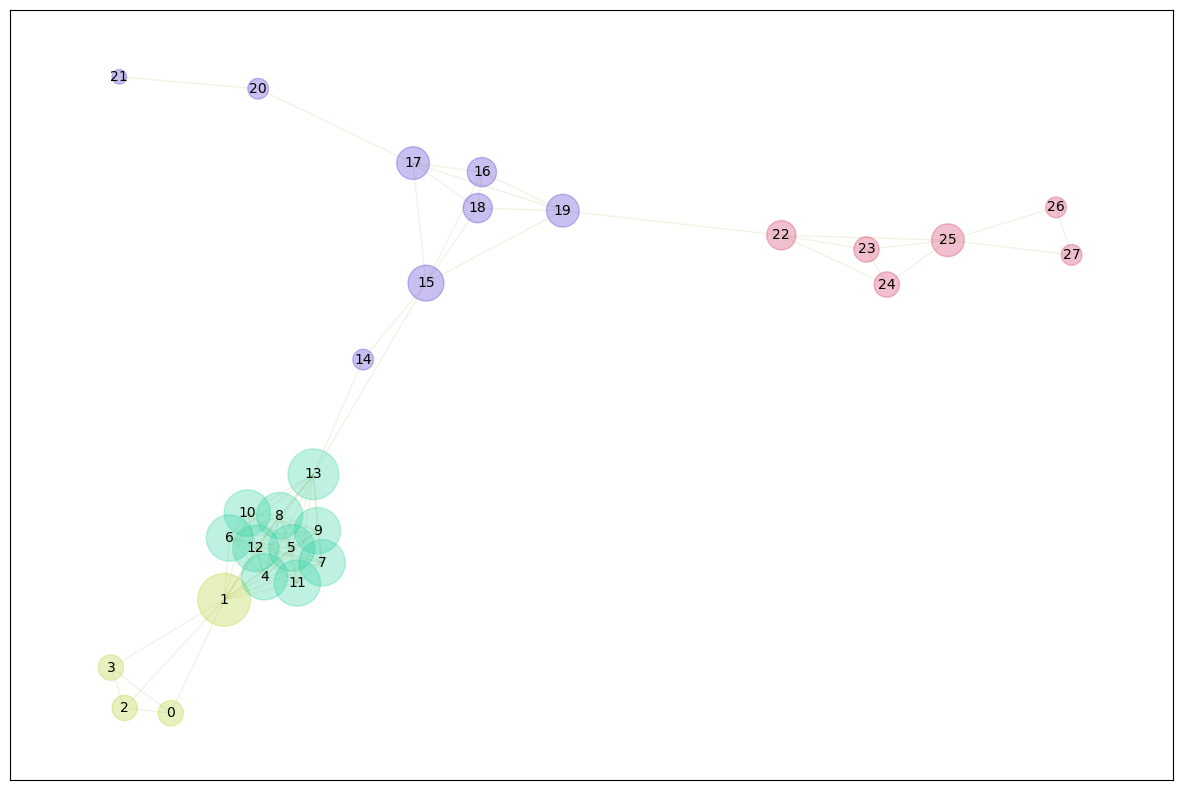

In [199]:
gnl.show_graph(Gds[3])

In [160]:
from collections import Counter

In [168]:
df = pd.concat([pd.DataFrame.from_dict(
    Counter(
        [
            x['name'] for (_,_,x) in Gs[i].edges(data=True)
        ]),
    orient='index', 
    columns=[i]) for i in range(len(Gs))], axis = 1).fillna(0)

In [169]:
df

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
FRAG,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
KOORD,1.0,2.0,0.0,2.0,0.0,3.0,0.0,5.0,4.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
SPRED,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
IP,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
KONJ,1.0,1.0,1.0,1.0,0.0,2.0,0.0,1.0,4.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
PUTFYLL,1.0,2.0,1.0,2.0,0.0,3.0,0.0,2.0,3.0,1.0,...,1.0,3.0,1.0,0.0,2.0,0.0,0.0,0.0,2.0,4.0
SUBJ,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,1.0,2.0,0.0,0.0,1.0,2.0,1.0,1.0,3.0,2.0
ADV,0.0,2.0,1.0,0.0,1.0,2.0,0.0,0.0,1.0,1.0,...,1.0,3.0,0.0,0.0,7.0,1.0,1.0,0.0,6.0,5.0
IK,0.0,1.0,1.0,5.0,2.0,2.0,2.0,4.0,5.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0,4.0,1.0
FINV,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0


In [157]:
Gds[10].nodes(data=True)

NodeDataView({0: {'name': 'ADV'}, 1: {'name': 'ADV'}, 2: {'name': 'IK'}, 3: {'name': 'KOORD'}, 4: {'name': 'FSPRED'}, 5: {'name': 'SUBJ'}, 6: {'name': 'DOBJ'}, 7: {'name': 'ADV'}, 8: {'name': 'ADV'}, 9: {'name': 'IP'}, 10: {'name': 'ADV'}, 11: {'name': 'IK'}, 12: {'name': 'FINV'}, 13: {'name': 'PUTFYLL'}, 14: {'name': 'PUTFYLL'}, 15: {'name': 'INFV'}, 16: {'name': 'DOBJ'}, 17: {'name': 'ATR'}, 18: {'name': 'PUTFYLL'}, 19: {'name': 'IK'}, 20: {'name': 'ADV'}, 21: {'name': 'IK'}, 22: {'name': 'KOORD'}, 23: {'name': 'FSPRED'}, 24: {'name': 'SUBJ'}, 25: {'name': 'DOBJ'}, 26: {'name': 'ADV'}, 27: {'name': 'ADV'}, 28: {'name': 'IP'}, 29: {'name': 'ADV'}, 30: {'name': 'IK'}, 31: {'name': 'FINV'}, 32: {'name': 'PUTFYLL'}, 33: {'name': 'PUTFYLL'}, 34: {'name': 'INFV'}, 35: {'name': 'DOBJ'}, 36: {'name': 'ATR'}, 37: {'name': 'PUTFYLL'}, 38: {'name': 'KOORD'}, 39: {'name': 'ADV'}, 40: {'name': 'IK'}, 41: {'name': 'KOORD'}, 42: {'name': 'FSPRED'}, 43: {'name': 'SUBJ'}, 44: {'name': 'DOBJ'}, 45: {'

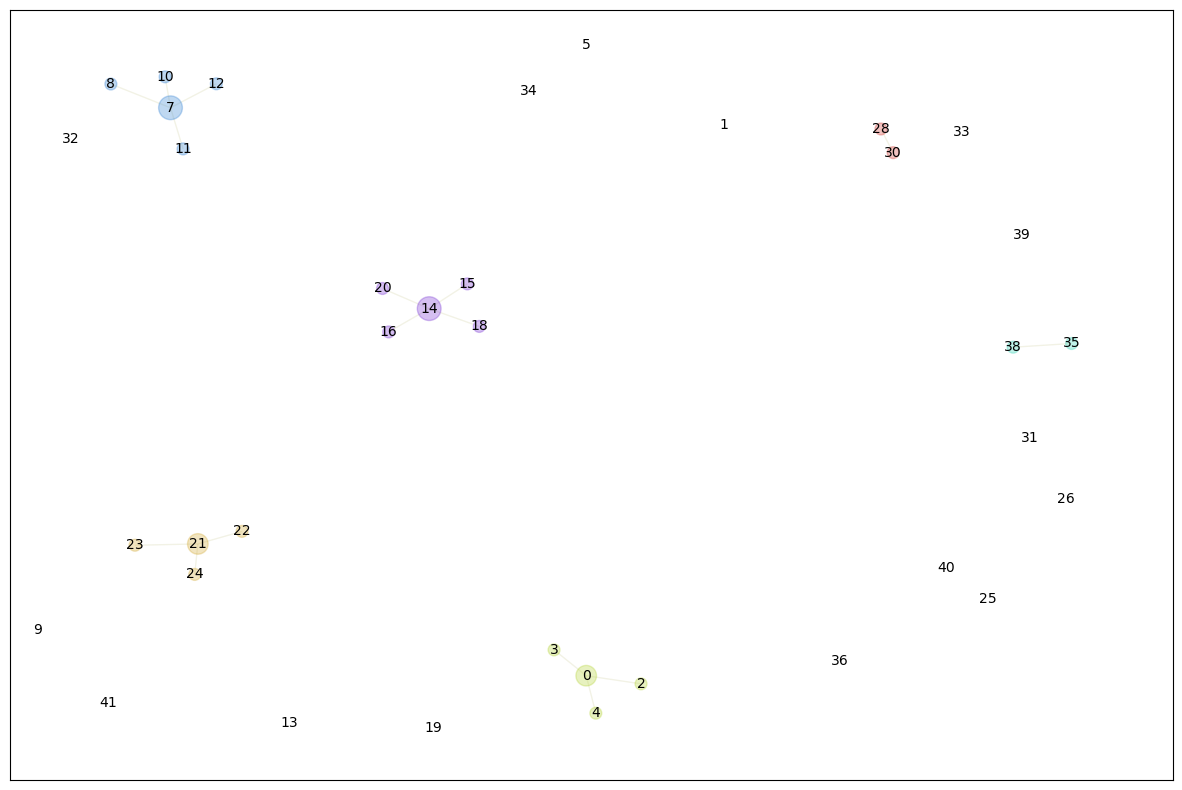

In [144]:
gnl.show_graph(Gds[0])

In [97]:
def to_frame(a_list, name='freq'):
    df = pd.DataFrame(a_list).set_index(0)
    df[name] = 1
    return df

In [100]:
outer_keys = range(100)  # Assuming this is your outer loop range

def inner_keys(G):
    return range(len(gnl.community_dict(G).values()))  # Replace this accordingly

result = pd.concat(
    [
        pd.concat(
            [to_frame(x, "") for j, x in enumerate(gnl.community_dict(Gds[i]).values())],
            axis=1,
            keys=inner_keys(Gds[i])  # Inner MultiIndex keys
        ) 
        for i in outer_keys  # Outer loop
    ],
    axis=1,
    keys=outer_keys  # Outer MultiIndex keys
).fillna(0)

In [ ]:
from sklearn.metrics.

In [175]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity


# Convert DataFrame to NumPy array
data_array = df.to_numpy()

# Compute cosine similarity for rows
similarity_rows = cosine_similarity(data_array)
#print("Cosine similarity between rows:")
#print(similarity_rows)

# Compute cosine similarity for columns
similarity_cols = cosine_similarity(data_array.T)
#print("Cosine similarity between columns:")
#p#rint(similarity_cols)


In [171]:
# Cosine similarity DataFrame for rows

similarity_df_rows = pd.DataFrame(similarity_rows, index=df.index, columns=df.index)

# Cosine similarity DataFrame for columns
similarity_df_cols = pd.DataFrame(similarity_cols, index=df.columns, columns=df.columns)


In [118]:
gnl.community_dict(Gds[72]).values()

dict_values([['SUBJ', 'INFV', 'IP', 'FINV'], ['ATR', 'PUTFYLL', 'DET'], ['ADV', 'SBU', 'DOBJ', 'IK'], ['KOORD', 'KONJ']])

In [119]:
gnl.community_dict(Gds[8]).values()

dict_values([['IK', 'PUTFYLL', 'ATR', 'KOORD'], ['KONJ', 'SUBJ', 'ADV', 'FINV', 'IP'], ['FLAT', 'APP']])

In [173]:
similarity_df_cols.sort_values(by=500,ascending=False) #.style.format(precision = 1).background_gradient()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
500,0.316228,0.651584,0.200000,0.485744,0.155700,0.651843,0.155700,0.422577,0.336191,0.387298,...,0.710047,0.585540,0.258199,0.447214,0.576461,0.408248,0.461880,0.182574,0.477028,0.812162
13,0.261116,0.684762,0.220193,0.506640,0.160706,0.748858,0.128565,0.488504,0.347001,0.426401,...,0.692902,0.644658,0.213201,0.492366,0.687552,0.404520,0.476731,0.150756,0.566221,0.878745
662,0.369274,0.691714,0.233550,0.537373,0.181818,0.761189,0.181818,0.493464,0.368050,0.452267,...,0.753778,0.683763,0.301511,0.522233,0.598366,0.476731,0.539360,0.213201,0.557048,0.850291
404,0.288675,0.540738,0.121716,0.420084,0.106600,0.543305,0.142134,0.385758,0.268536,0.235702,...,0.530330,0.400892,0.235702,0.408248,0.380058,0.298142,0.316228,0.166667,0.272166,0.690268
143,0.288675,0.702959,0.243432,0.490098,0.142134,0.646792,0.106600,0.437193,0.364442,0.471405,...,0.707107,0.668153,0.353553,0.408248,0.584705,0.447214,0.421637,0.166667,0.489898,0.818096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
900,0.408248,0.114708,0.258199,0.049507,0.075378,0.054882,0.075378,0.109109,0.040689,0.500000,...,0.125000,0.094491,0.500000,0.577350,0.186052,0.158114,0.223607,0.176777,0.115470,0.108465
987,0.333333,0.093659,0.843274,0.444649,0.800095,0.044811,0.800095,0.089087,0.564787,0.408248,...,0.306186,0.077152,0.408248,0.471405,0.050637,0.129099,0.182574,0.144338,0.047140,0.044281
211,0.308607,0.260133,0.683130,0.598785,0.626783,0.207435,0.626783,0.412393,0.584408,0.377964,...,0.377964,0.214286,0.377964,0.436436,0.046881,0.358569,0.507093,0.668153,0.392792,0.122988
27,0.721688,0.567775,0.365148,0.385077,0.159901,0.426883,0.159901,0.655789,0.517892,0.353553,...,0.441942,0.334077,0.353553,0.408248,0.043853,0.223607,0.316228,0.375000,0.326599,0.191741


In [ ]:
# Collapse rows (index)
df = similarity_df_cols
collapsed_df_rows = df.groupby(level=0).mean()

# Collapse columns
collapsed_df = collapsed_df_rows.groupby(level=0, axis=1).mean()

print("Collapsed DataFrame:")

In [125]:
collapsed_df.style.format(precision=2).background_gradient()

In [126]:
gnl.community_dict(Gds[11])

{'KOORD-PUTFYLL': ['KOORD', 'PUTFYLL', 'ATR', 'KONJ'],
 'IK-SUBJ': ['IK', 'SUBJ', 'ADV', 'FINV', 'IP', 'APP']}

In [127]:
gnl.community_dict(Gds[18])

{'PUTFYLL-ATR': ['PUTFYLL', 'ATR', 'DET'],
 'ADV-FINV': ['ADV', 'FINV', 'FSUBJ', 'IP', 'SPRED'],
 'PSUBJ-INFV': ['PSUBJ', 'INFV', 'SUBJ', 'SBU']}